## Project: Electricity Analysis

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_financial as npf

### 1. Load the data

In [191]:
names = ['Hour', 'DateTimeStamp', 'Solar generation', 'Electricity usage']
electricity_data = pd.read_excel('Junior Data Analyst _ Data.xlsx',header=0,skiprows=2,names=names)


### 2. Preliminary Data Analysis

Through methods embedded in dataframes we can easily profile our data. We see:
* There are no missing values
* Data types are consistent
* Outliers are present and need to be handled

In [192]:
electricity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Hour               8760 non-null   int64         
 1   DateTimeStamp      8760 non-null   datetime64[ns]
 2   Solar generation   8760 non-null   float64       
 3   Electricity usage  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 273.9 KB


In [193]:
# Describe numeric data
electricity_data.describe(include=np.number)

,Hour,Solar generation,Electricity usage
count,8760.000000,8760.000000,8760.000000
mean,11.500000,1.116750,7.312704
std,6.922582,2.026098,491.479806
min,0.000000,0.000000,-12.624000
25%,5.750000,0.000000,0.300000
50%,11.500000,0.024000,0.621000
75%,17.250000,1.272750,1.686000
max,23.000000,13.050000,46000.000000


### 3. Data Preparation

To prepare our data, abnormal values are handled.

1. Absolute values are considered to handle negative inputs
2. Extreme outliers are corrected with the average value of the group.

In [194]:
#calculate absolute value to handle negatives
electricity_data['Electricity usage']=electricity_data['Electricity usage'].abs()

# Calculate the average value and standard deviation of Electricity usage
usage_avg = electricity_data['Electricity usage'].mean()
usage_std = electricity_data['Electricity usage'].std()

# Outliers are values more than 3-times the standard deviation
outliers = electricity_data[(electricity_data['Electricity usage'] - usage_avg).abs() > 3 * usage_std]

# Replace outliers with the average value
electricity_data.loc[outliers.index, 'Electricity usage'] = usage_avg

### 4. Data Calculations

* Hourly Calculations 

Take the average of the Hour group for each entry

([<matplotlib.axis.XTick at 0x21d231de900>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

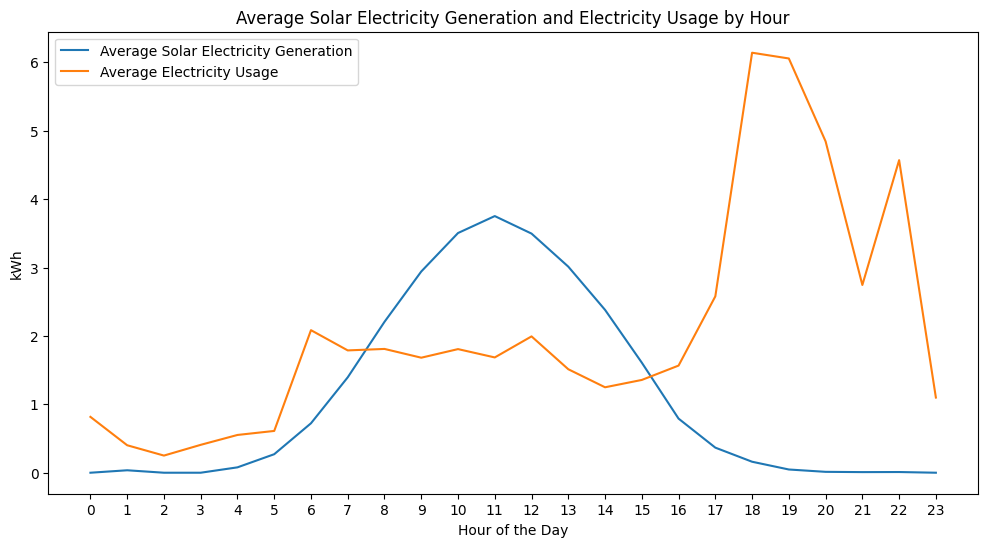

In [195]:
hourly_data = electricity_data[['Hour','Solar generation', 'Electricity usage']]
hourly_avg = hourly_data.groupby('Hour').mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg['Solar generation'], label='Average Solar Electricity Generation')
plt.plot(hourly_avg.index, hourly_avg['Electricity usage'], label='Average Electricity Usage')
plt.title('Average Solar Electricity Generation and Electricity Usage by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('kWh')
plt.legend()
plt.xticks(range(24))

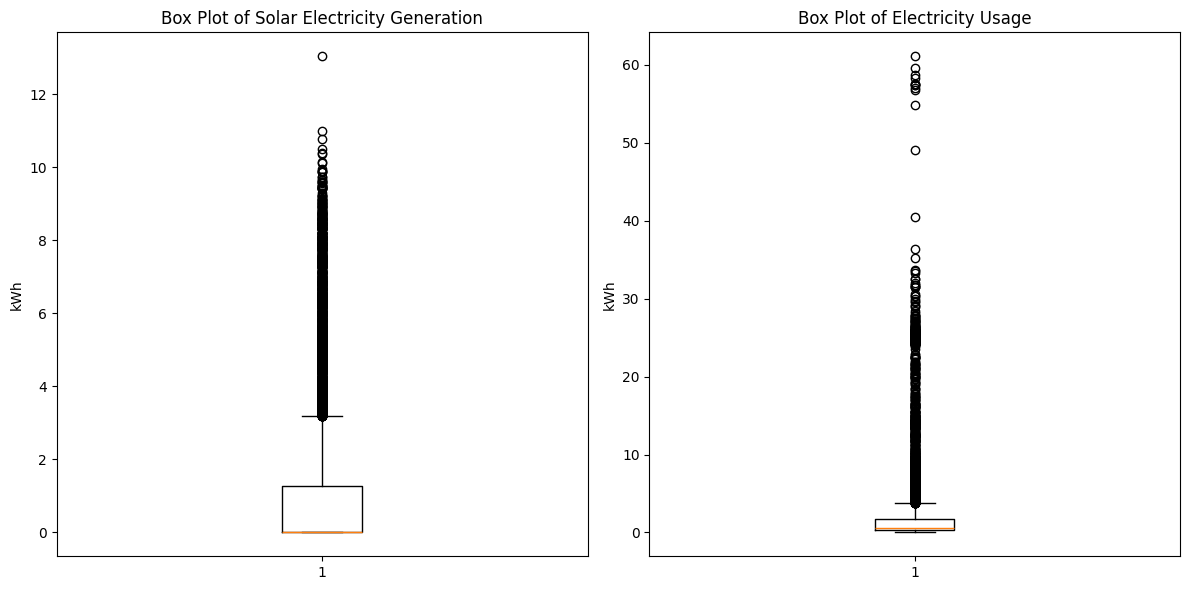

In [196]:
plt.figure(figsize=(12, 6))

# Box plot for Solar electricity generation
plt.subplot(1, 2, 1)  # Creating a subplot
plt.boxplot(hourly_data['Solar generation'])
plt.title('Box Plot of Solar Electricity Generation')
plt.ylabel('kWh')

# Box plot for Electricity usage
plt.subplot(1, 2, 2)  # Creating a subplot
plt.boxplot(hourly_data['Electricity usage'])
plt.title('Box Plot of Electricity Usage')
plt.ylabel('kWh')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

* Provider Electricity

Take the difference of usage and solar output

In [197]:
# Calculate the amount of electricity needed to be bought from the electricity provider
electricity_data['Provider Electricity'] = electricity_data['Electricity usage'] - electricity_data['Solar generation']
electricity_data['Provider Electricity'] = electricity_data['Provider Electricity'].apply(lambda x: max(0, x))

* Solar Excess

Difference of Solar output and Electricity usage

In [198]:
# Calculate excess solar output
electricity_data['Excess Solar'] = electricity_data['Solar generation'] - electricity_data['Electricity usage']
electricity_data['Excess Solar'] = electricity_data['Excess Solar'].apply(lambda x: max(0, x))

* Battery Charge Levels

Using the field **Excess Solar** and **Provider Electicity** we determine the charge level. If Excess Solar then charge the battery else discharge the battery according to Provider Electricity. All values should be above 0 and less than capacity

In [199]:
battery_capacity = 12.5 
battery_charge_level = 0
battery_charge_levels = []

# Iterate through each hour of 2020 data
for index, row in electricity_data.iterrows():
    # Get the excess solar electricity generated over electricity used
    excess_solar_electricity = row['Excess Solar']
    
    # Get the amount of electricity needed to be bought from the electricity provider
    electricity_from_provider = row['Provider Electricity']
    
    # Update battery charge level
    # Charge the battery if there is excess solar electricity
    battery_charge_level += excess_solar_electricity
    # Discharge the battery if electricity needs to be bought from the provider
    battery_charge_level -= electricity_from_provider
    
    # Ensure battery charge level does not exceed maximum capacity
    battery_charge_level = min(battery_charge_level, battery_capacity)
    
    # Ensure battery charge level does not go below zero
    battery_charge_level = max(battery_charge_level, 0)
    
    # Store the battery charge level
    battery_charge_levels.append(battery_charge_level)

# Add battery charge level to the data
electricity_data['Battery charge level'] = battery_charge_levels

In [200]:
# Calculate the amount of electricity bought from the electricity provider

# Shift the data to use previous hour value. 
electricity_data['Provider Electricity (Battery)'] = electricity_data['Electricity usage'] - electricity_data['Solar generation'] - electricity_data['Battery charge level'].shift(1)
electricity_data['Provider Electricity (Battery)'].fillna(electricity_data['Provider Electricity'].iloc[0],inplace=True) # Handle missing initial value
electricity_data['Provider Electricity (Battery)'] = electricity_data['Provider Electricity (Battery)'].apply(lambda x: max(0, x))

C:\Users\user\AppData\Local\Temp\ipykernel_17344\3818017237.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  electricity_data['Provider Electricity (Battery)'].fillna(electricity_data['Provider Electricity'].iloc[0],inplace=True)


* Calculate Savings

We get the `usage_diff` by taking the difference purchased from the provider assuming conditions of a battery in place or not and multiply with our standard rate.

In [233]:
# Calculate the electricity usage without battery
electricity_usage_without_battery = electricity_data['Provider Electricity'].sum()

# Calculate the electricity usage with battery
electricity_usage_with_battery = electricity_data['Provider Electricity (Battery)'].sum()

#Usage difference
usage_diff = electricity_usage_without_battery - electricity_usage_with_battery

# Electricity price
electricity_price = 0.17  # $ per kWh

# Calculate the savings
savings = usage_diff * electricity_price

print("Savings over 2020 from installing a battery compared to using existing solar panels alone: ${:.2f}".format(savings))


Savings over 2020 from installing a battery compared to using existing solar panels alone: $594.78


* Plotting Monthly Figures

In [207]:
# Extract month from the DateTimeStamp
electricity_data['Month'] = electricity_data['DateTimeStamp'].dt.month

# Group electricity_data by month and sum the values
monthly_electricity_data = electricity_data.groupby(['Month']).agg({
    'Solar generation': 'sum',
    'Electricity usage' : 'sum',
    'Provider Electricity': 'sum',
    'Provider Electricity (Battery)': 'sum'
}).reset_index()


In [215]:
# Display the tabular data
monthly_electricity_data

,Month,Solar generation,Electricity usage,Provider Electricity,Provider Electricity (Battery)
0,1,266.259,1737.745329,1614.322329,1482.203329
1,2,449.634,1562.279810,1395.152810,1193.261810
2,3,602.451,1797.859450,1619.011450,1384.846450
3,4,915.132,1726.356487,1460.504519,1144.120799
4,5,1641.360,948.831809,718.662809,339.930493
5,6,1408.287,1158.995538,844.784538,447.593233
6,7,1371.465,1196.957121,907.445121,470.627352
7,8,1158.639,1491.525351,1217.886351,792.621935
8,9,835.680,1624.668165,1400.094165,1042.098360
9,10,546.132,1420.745585,1260.335585,967.353412


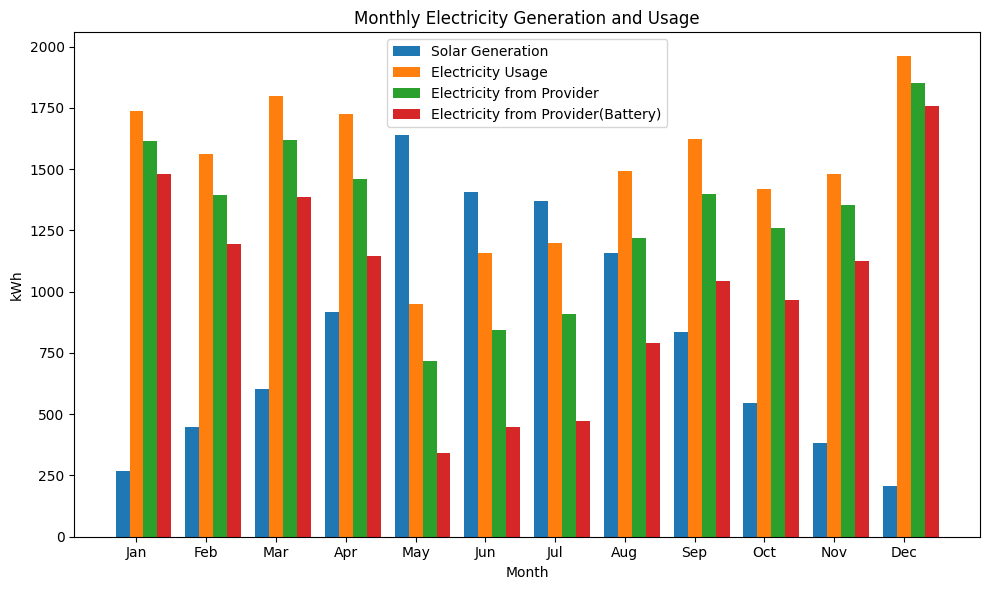

In [214]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(monthly_electricity_data['Month'] - 0.2, monthly_electricity_data['Solar generation'], width=0.2, label='Solar Generation')
plt.bar(monthly_electricity_data['Month'], monthly_electricity_data['Electricity usage'], width=0.2, label='Electricity Usage')
plt.bar(monthly_electricity_data['Month'] + 0.2, monthly_electricity_data['Provider Electricity'], width=0.2, label='Electricity from Provider')
plt.bar(monthly_electricity_data['Month'] + 0.4, monthly_electricity_data['Provider Electricity (Battery)'], width=0.2, label='Electricity from Provider(Battery)')

plt.xlabel('Month')
plt.ylabel('kWh')
plt.title('Monthly Electricity Generation and Usage')
plt.xticks(monthly_electricity_data['Month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

* Calculate the annual savings projected for 20 years

In [235]:
initial_electricity_price = 0.17  
annual_increase_percentage = 0.04  # annual increase in electricity price (4%)


# Calculate annual savings for each year
annual_savings_scenario_1 = []
for year in range(2022, 2041):
    electricity_price = initial_electricity_price * ((1 + annual_increase_percentage) ** (year-2022))
    
    annual_savings = electricity_price * usage_diff
    annual_savings_scenario_1.append(annual_savings)

# Calculate total annual savings for 20 years
total_annual_savings_scenario_1 = sum(annual_savings_scenario_1)

print("Total annual savings for scenario 1 (4% annual increase): $", round(total_annual_savings_scenario_1, 2))


Total annual savings for scenario 1 (4% annual increase): $ 16458.38


In [241]:
annual_increase_percentage = 0.04  # initial annual increase in electricity price (4%)
additional_annual_increase = 0.0025  # additional annual increase (0.25%)


# Calculate annual savings for each year
annual_savings_scenario_2 = []
for year in range(2022,2041 ):
    if year <= 2023:
        inflation = ((1 + annual_increase_percentage) ** (year-2022))
        electricity_price = initial_electricity_price * inflation
    else:
        inflation = (inflation + (additional_annual_increase * ((year-2022)-1)))
        electricity_price = initial_electricity_price * inflation
    annual_savings = electricity_price * usage_diff  
    annual_savings_scenario_2.append(annual_savings)

# Calculate total annual savings for 20 years
total_annual_savings_scenario_2 = sum(annual_savings_scenario_2)

print("Total annual savings for scenario 2 (4% initial increase + 0.25% additional increase): $", round(total_annual_savings_scenario_2, 2))


Total annual savings for scenario 2 (4% initial increase + 0.25% additional increase): $ 13169.98


* Define functions for NPV and IRR

In [250]:

# Define function to calculate NPV for each scenario
def npv_function(discount, annual_savings):
    return sum([savings / ((1 + discount) ** (year - 2022)) for year, savings in enumerate(annual_savings, start=2022)])

# Function to calculate IRR
def irr_function(annual_savings, initial_cost):
    average_annual_savings = annual_savings / 20  # Divide total savings by 20 for average annual savings
    cash_flows = [-initial_cost] + [average_annual_savings] * 20
    return npf.irr(cash_flows)



In [247]:
npv_scenario_1 = npv_function(0.06, annual_savings_scenario_1)
npv_scenario_2 = npv_function(0.06, annual_savings_scenario_2)

print("NPV for Scenario 1: ${:.2f}".format(npv_scenario_1))
print("NPV for Scenario 2: ${:.2f}".format(npv_scenario_2))

NPV for Scenario 1: $9572.39
NPV for Scenario 2: $7943.64


In [251]:
# Initial cost of the battery
initial_cost = 7000  # $

# Calculate IRR for Scenario 1
irr_scenario_1 = irr_function(total_annual_savings_scenario_1, initial_cost)

# Calculate IRR for Scenario 2
irr_scenario_2 = irr_function(total_annual_savings_scenario_2, initial_cost)

print("IRR for Scenario 1: {:.2f}%".format(irr_scenario_1 * 100))
print("IRR for Scenario 2: {:.2f}%".format(irr_scenario_2 * 100))


IRR for Scenario 1: 10.01%
IRR for Scenario 2: 6.96%
